In [34]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/description.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt


In [35]:
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [36]:
train_place ='/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt'
train_data=pd.read_csv( train_place , sep=':::',engine='python',names=['Title','Genre','Description'])
train_data.head()



,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [37]:
test_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_data.head()

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [39]:
train_data.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [40]:
(train_data.isnull().sum())

Title          0
Genre          0
Description    0
dtype: int64

Text(0, 0.5, 'Genre')

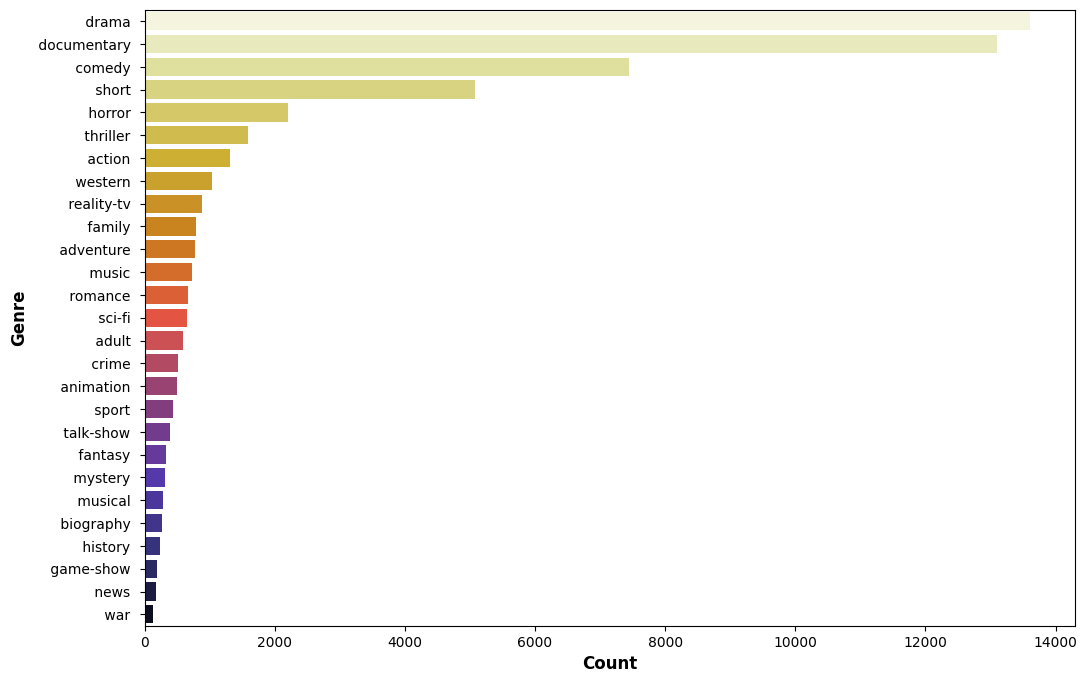

In [41]:
plt.figure(figsize=(12, 8))
sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, palette='CMRmap_r')
plt.xlabel('Count', fontsize=12, fontweight='bold')
plt.ylabel('Genre', fontsize=12, fontweight='bold')

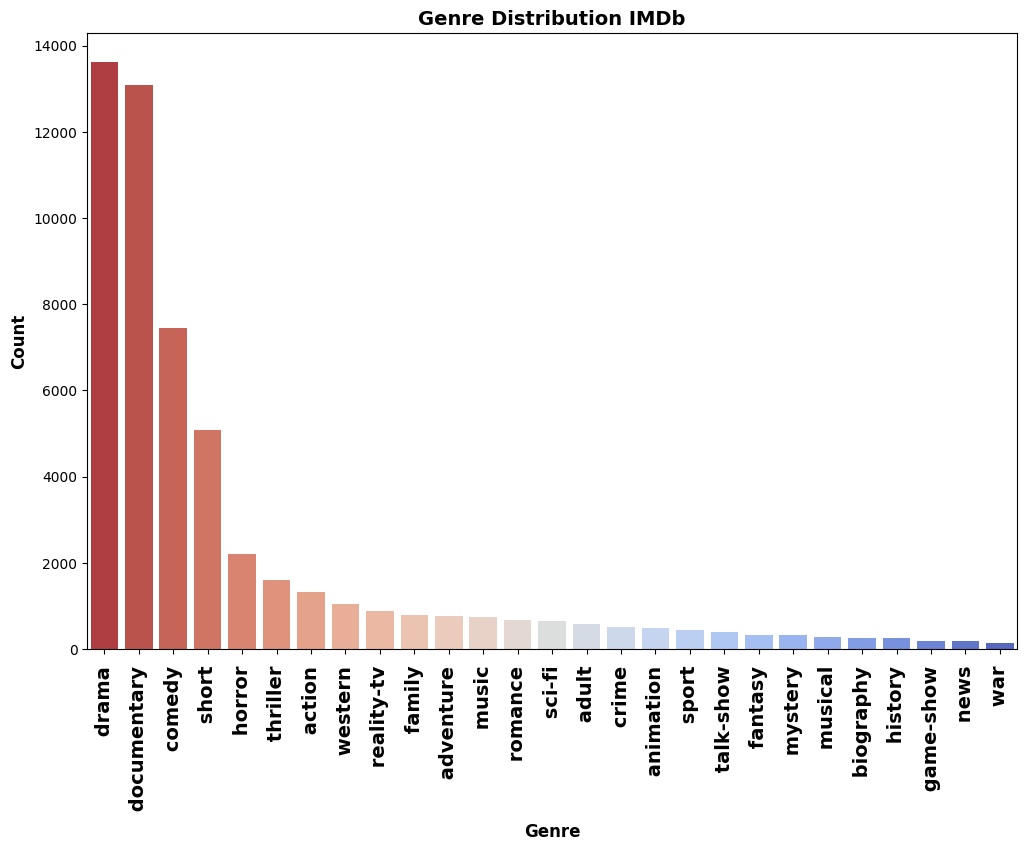

In [42]:


plt.figure(figsize=(12, 8))
counts = train_data['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='coolwarm_r')
plt.xlabel('Genre', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12,  fontweight='bold' )
plt.title('Genre Distribution IMDb', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

In [43]:
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [44]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def text_clean(text):
    text = text.lower()                                 
    text =  re.sub(r'@\S+', '',text)                     
    text =  re.sub(r'http\S+', '',text)               
    text =  re.sub(r'pic.\S+', '',text) 
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)           
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')    
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            
    return text
train_data['Text_cleaning'] = train_data['Description'].apply(text_clean)
test_data['Text_cleaning'] = test_data['Description'].apply(text_clean)
train_data.head()
 

,Title,Genre,Description,Text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films title refers recovered bodies ground zer...


In [45]:
train_data['length_Text_cleaning']=train_data['Text_cleaning'].apply(len)
train_data.head()

,Title,Genre,Description,Text_cleaning,length_Text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...,383
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...,119
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...,402
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...,745
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films title refers recovered bodies ground zer...,402


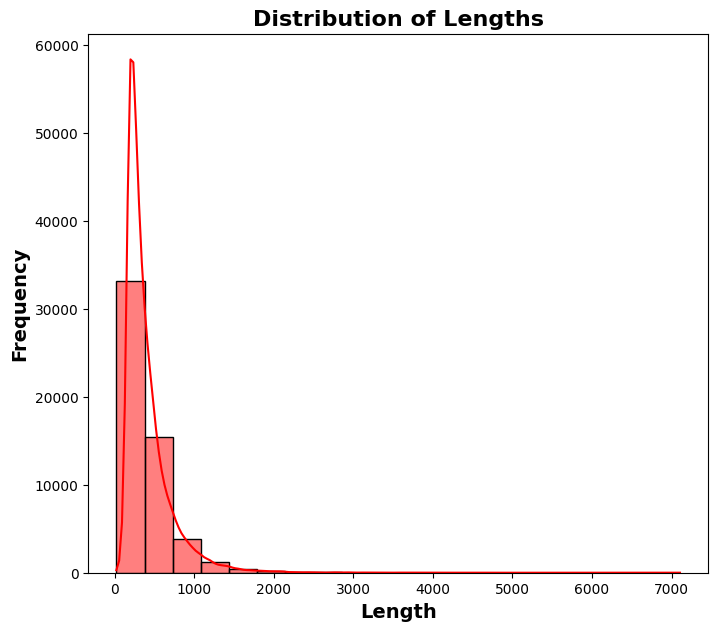

In [50]:
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='red')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

In [51]:
#Remove extremely long descriptions: outliers
print('Dataframe size (before removal): ',len(train_data))
filt=train_data['length_Text_cleaning']>2000
train_data.drop(train_data[filt].index,axis=0,inplace=True)     # filter rows having cleaned description length > 2000
print('Dataframe size (after removal): ',len(train_data))
print(f'Removed rows: {filt.sum()}')

Dataframe size (before removal):  54214
Dataframe size (after removal):  54014
Removed rows: 200


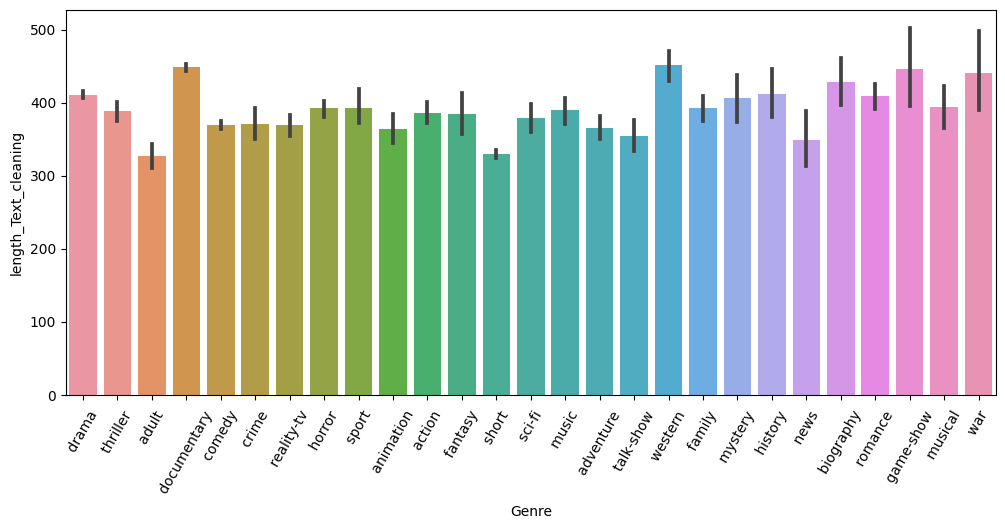

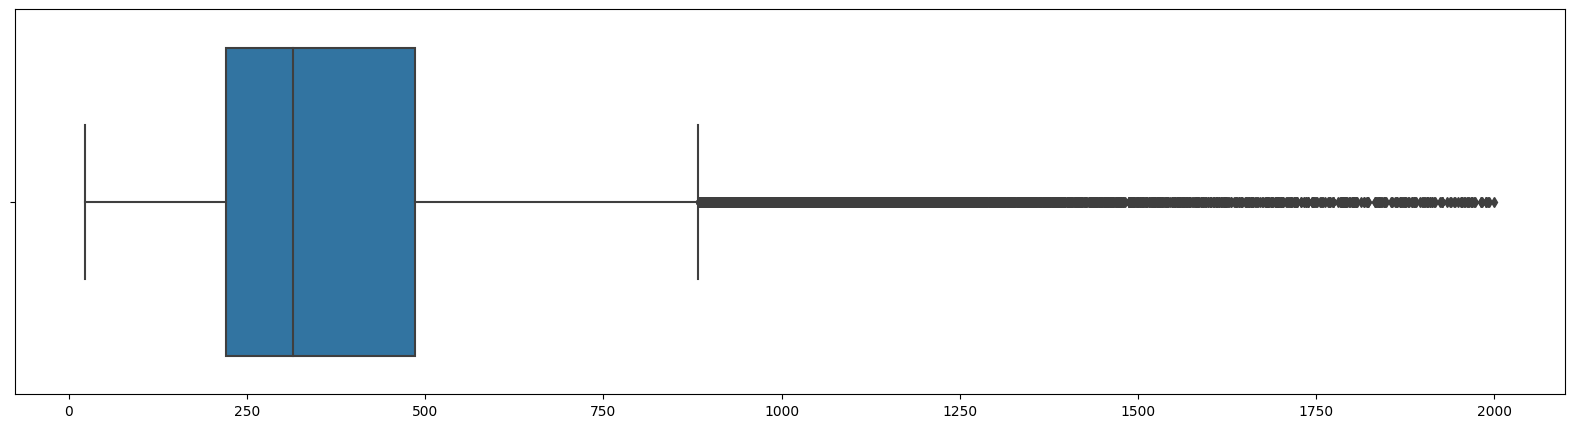

In [52]:
plt.figure(figsize=(12,5))
sns.barplot(x='Genre',y='length_Text_cleaning',data=train_data)  # from 600ish to 350ish -> significant reduction in length
plt.xticks(rotation=60)
plt.show()
plt.figure(figsize=(20,5))
sns.boxplot(x=train_data['length_Text_cleaning'].values,hue='Genre',data=train_data)
plt.show()

Text Vectorization Using TF-IDF

In [55]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

Split Data and Training Multinomial Naive Bayes Model

In [56]:
# Split the data into training and validation sets
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.4387670091641211
               precision    recall  f1-score   support

      action        0.00      0.00      0.00       270
       adult        0.00      0.00      0.00       111
   adventure        0.00      0.00      0.00       155
   animation        0.00      0.00      0.00       102
   biography        0.00      0.00      0.00        46
      comedy        0.54      0.03      0.06      1469
       crime        0.00      0.00      0.00        92
 documentary        0.53      0.88      0.67      2643
       drama        0.37      0.88      0.52      2665
      family        0.00      0.00      0.00       162
     fantasy        0.00      0.00      0.00        61
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        60
      horror        0.00      0.00      0.00       408
       music        0.00      0.00      0.00       152
     musical        0.00      0.00      0.00        57
     mystery        0.00

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Make Predictions on the Test Data

In [57]:
# Use the trained model to make predictions on the test data
X_test_predictions = classifier.predict(X_test)
test_data['Predicted_Genre'] = X_test_predictions

In [58]:
# Save the test_data DataFrame with predicted genres to a CSV file
test_data.to_csv('predicted_genres.csv', index=False)

# Display the 'test_data' DataFrame with predicted genres
print(test_data)

          Id                             Title  \
0          1             Edgar's Lunch (1998)    
1          2         La guerra de papá (1977)    
2          3      Off the Beaten Track (2010)    
3          4           Meu Amigo Hindu (2015)    
4          5                Er nu zhai (1955)    
...      ...                               ...   
54195  54196   "Tales of Light & Dark" (2013)    
54196  54197      Der letzte Mohikaner (1965)    
54197  54198              Oliver Twink (2007)    
54198  54199                Slipstream (1973)    
54199  54200        Curitiba Zero Grau (2010)    

                                             Description  \
0       L.R. Brane loves his life - his car, his apar...   
1       Spain, March 1964: Quico is a very naughty ch...   
2       One year in the life of Albin and his family ...   
3       His father has died, he hasn't spoken with hi...   
4       Before he was known internationally as a mart...   
...                                    

In [63]:
test_data.head(10)

,Id,Title,Description,Text_cleaning,Predicted_Genre
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...,drama
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...,drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...,documentary
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...,drama
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...,drama
5,6,Riddle Room (2016),Emily Burns is being held captive in a room w...,emily burns held captive room idea got determi...,drama
6,7,L'amica (1969),The beautiful but neglected wife of a brillia...,beautiful neglected wife brilliant architect m...,drama
7,8,Ina Mina Dika (1989),Vasu Inamdar (Ina) suffers from a disorder wh...,vasu inamdar ina suffers disorder sees comes d...,drama
8,9,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...,insight tornados hit kensal rise birmingham su...,documentary
9,10,Press (2011),Press is a story of young people overwhelmed ...,press story young people overwhelmed social di...,drama
